# Regressor Chain

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from notebook_utils import scores_barplot, print_avg_scores, mo_reg_scorer
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from ChainRegressor import ChainRegressor


pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)
sns.set_theme(style="whitegrid")

## Import & Prepare Data

In [2]:
# Load dataset from csv
data = pd.read_csv("..\\data\\dataset-merged.csv")

# Drop unwanted columns
data.drop(['sheepid'], axis=1, inplace=True)
data.drop(['slaughgr'], axis=1, inplace=True)
data.drop(['sex'], axis=1, inplace=True)
data.drop(['breed'], axis=1, inplace=True)

print(data.head())

   slweight(g)  woolfr  blood  feet  pelt  fullGI  mesent  epipl  liver  spleen  pluck  head  warmcarc  kidney  KKCF  tail  coldcarc  mw%  WtBefDIS  LEG  CHUMP  LOIN  BREAST  BESTEND  MIDNECK  SHOULDER  NECK
0        12399     150    575   450  1250    1400     100    150    275      30    425   635      6850      32   122    32      6612   25      3280  820    307   336     323      236      477       665   110
1        12500     130    575   475  1245    1500      75     75    300      50    525   650      6800      32    78    32      6542   25      3180  803    298   322     290      242      454       682    94
2        12300     140    600   475  1200    1300     100    125    275      50    400   625      6875      32   118    44      6776   25      3350  812    350   328     316      238      500       670   130
3        12399     120    625   450  1225    1375     125    250    300      50    400   650      6850      34   154    32      6642   25      3290  846    274   358   

In [3]:
# Scale dataset
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Split independent variables from target variables
input_cols = ['slweight(g)']
X = data_scaled[input_cols]
y = data_scaled.drop(input_cols, axis=1)

# TrainTestSplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)
# Reset indices
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

## Linear Regression Random Chain
Αρχικά, θα μετρήσουμε την απόδοση ενός chain regressor με χρήση αποκλειστικά Linear Regression μοντέλου και τυχαία σειρά
στη πρόβλεψη των μεταβλητών, προκειμένου να πάρουμε κάποιες baseline μετρήσεις.

Linear Regression Random Chain
R2 score: 0.8271968148229818
MAE: 0.23517501710752023
RMSE: 0.3086577502857589
MAPE: 1.551649626343731



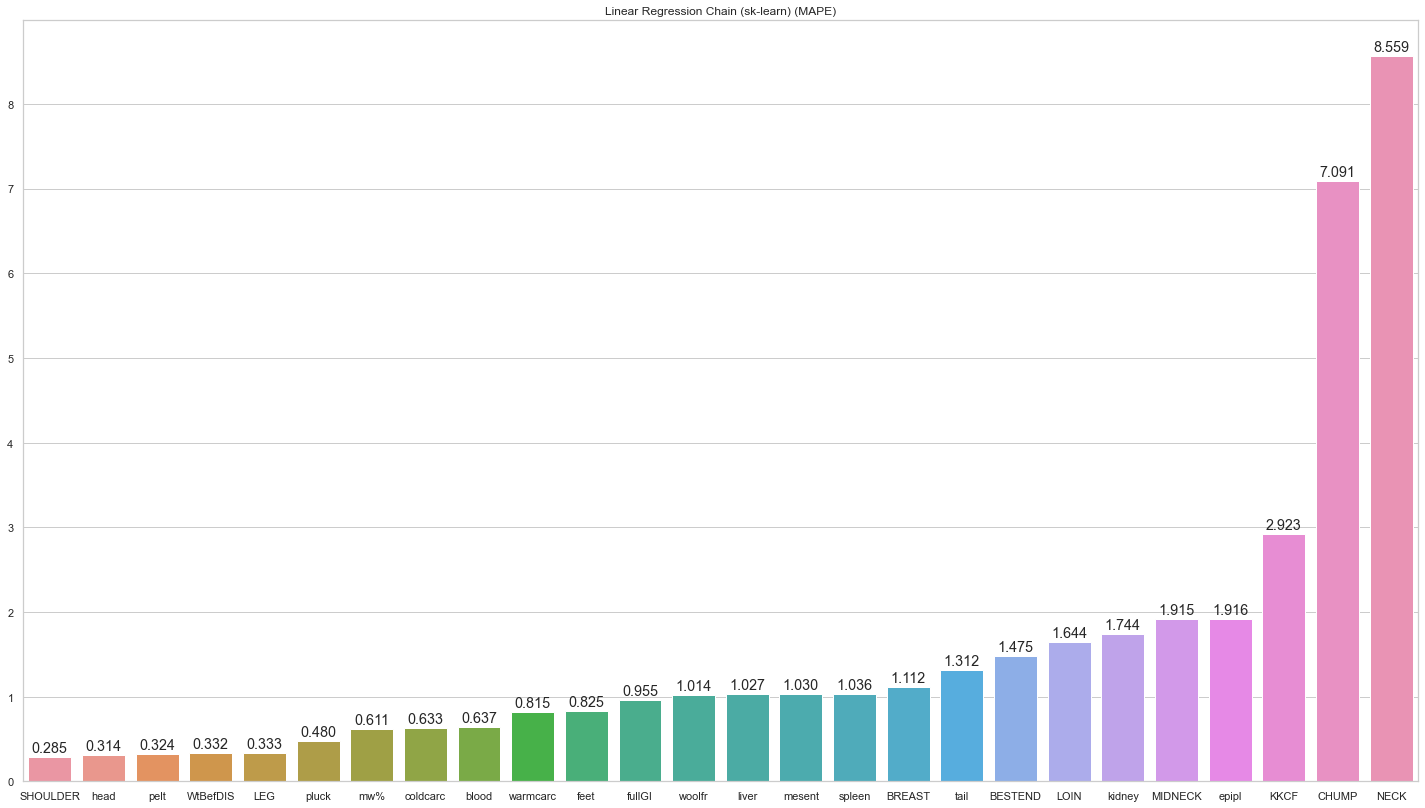

In [4]:
# Try scikit-learn chain regressor with linear regression base model & random chain order
mod = RegressorChain(LinearRegression(), order='random')
mod.fit(X_train, y_train)
scores = mo_reg_scorer(mod, X_test, y_test)
print_avg_scores(scores, 'Linear Regression Random Chain')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Linear Regression Chain (sk-learn) (MAPE)')

Συγκριτικά με την επίδοση του Linear Regression χωρίς chain meta-regressor που είδαμε στο Notebook "EDA_notebook" ο
Chain Linear Regression έχει ακριβώς το ίδιο σφάλμα σε όλες τις μεταβλητές. (??)

## XGBoost
Επίσης, θα μετρήσουμε την απόδοση ενός chain regressor με χρήση αποκλειστικά XGBoost μοντέλου και τυχαία σειρά
στη πρόβλεψη των μεταβλητών, προκειμένου να πάρουμε μερικές ακόμα baseline μετρήσεις.

XGBoost Random Chain
R2 score: 0.836373425968967
MAE: 0.22777630246552788
RMSE: 0.2973552141140641
MAPE: 1.3005349753706654



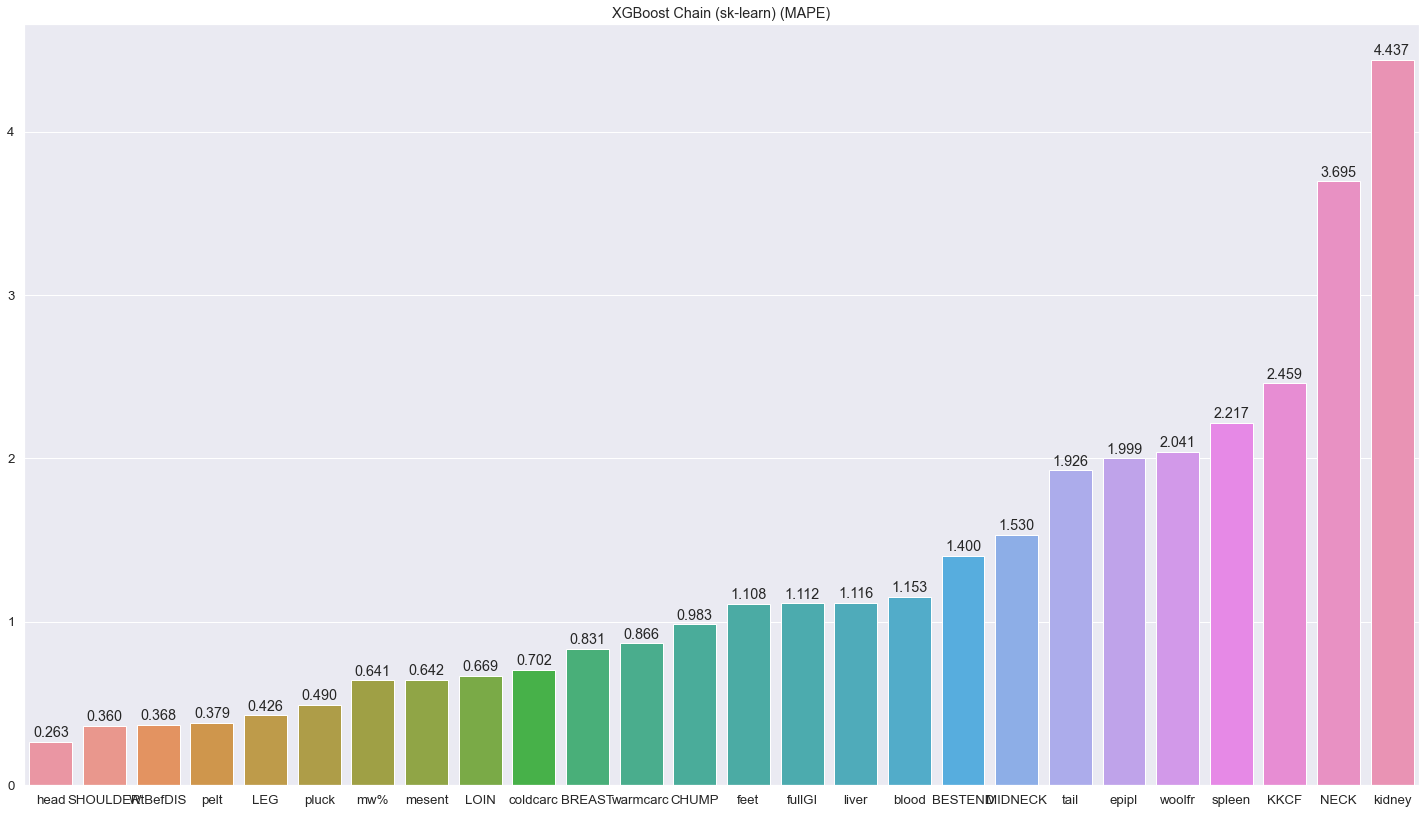

In [5]:
# Try scikit-learn chain regressor with XGBoost base model & random chain order
mod = RegressorChain(xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1,
                                      max_depth=4, n_estimators=90, n_jobs=-1), order='random')
mod.fit(X_train, y_train)
scores = mo_reg_scorer(mod, X_test, y_test)
print_avg_scores(scores, 'XGBoost Random Chain')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='XGBoost Chain (sk-learn) (MAPE)')

Συγκριτικά με την επίδοση του Linear Regression χωρίς chain meta-regressor που είδαμε στο Notebook "EDA_notebook" ο
Chain XGBoost έχει μειωμένο MAPE ακόμα και με χρήση τυχαίας σειράς των μεταβλητών.

## Custom Regressor Chain
Στη συνέχεια, θα κατασκευάσουμε έναν custom chain regressor ο οποίος επιτρέπει τη χρήση διαφορετικών μοντέλων σε κάθε
στάδιο της αλυσίδας με σκόπο να τη βελτίωση των αποτελεσμάτων.

* Γνωρίζουμε ότι τα χαρ/κα WtBefDIS, warmcarc και coldcarc είναι γραμμικά εξαρτημένα απο το χαρ/κο slweight και έχουν υψηλή
συσχέτιση με αυτό όπως είδαμε. Επίσης, όπως είδαμε και στο EDA_notebook, τα τρία αυτά χαρ/κά συμμετέχουν και είναι
σημαντικά για τη πρόβλεψη των υπολοιπων εξαρτημένων μεταβλητών. Επομένως, θα ξεκινήσουμε την αλυσίδα προβλέποντας αυτά
τα χαρ/κα.

* Στη συνέχεια, θα κατασκευάσουμε τον chain regressor με βάση τα feature importances των μεταβλητών.

Custom Chain Regressor Based on Feature Importances #1
R2 score: 0.8307288652788276
MAE: 0.21426754453683872
RMSE: 0.29946093165147303
MAPE: 1.2536908384054537



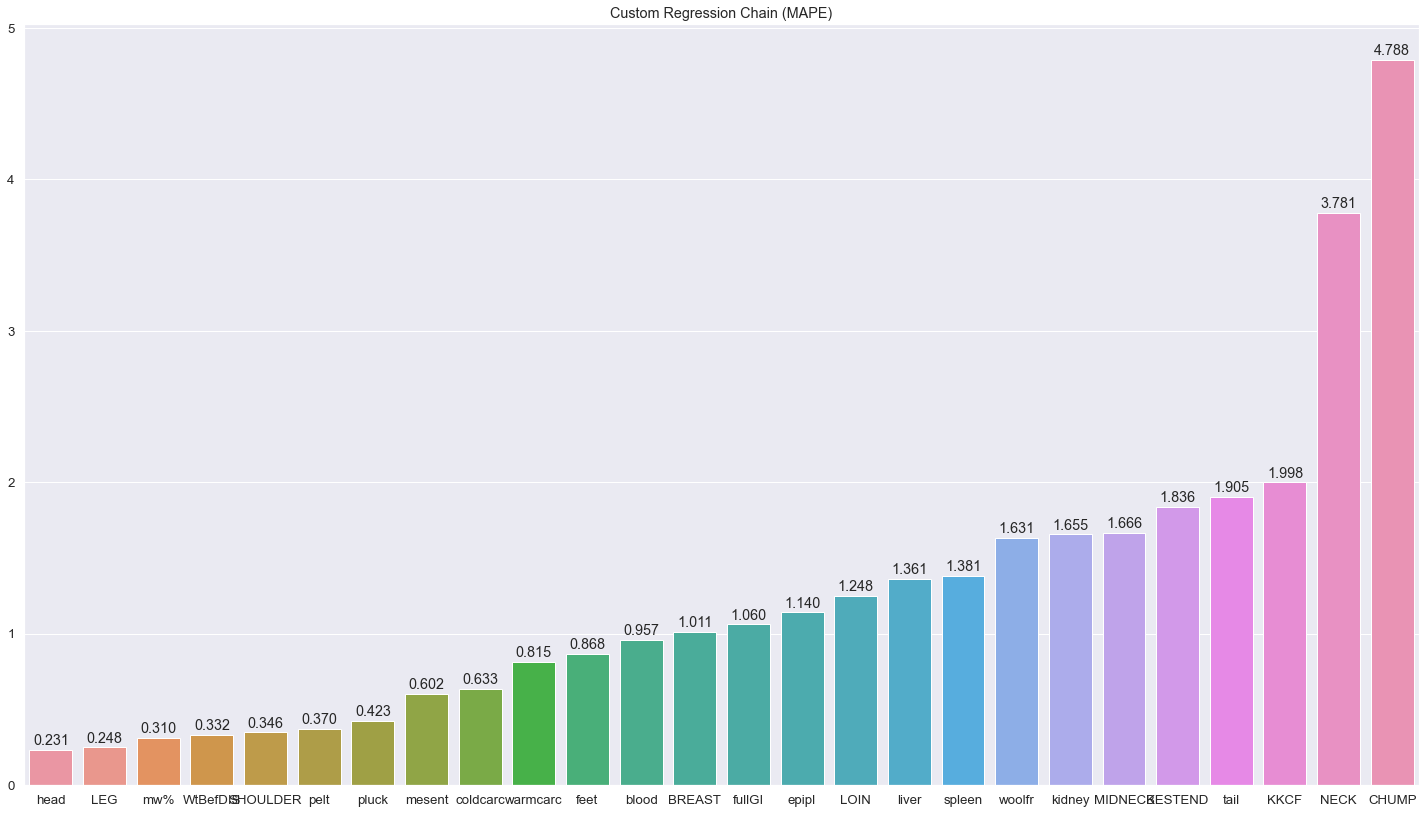

In [6]:
xgb_reg = xgb.XGBRegressor(colsample_bytree=0.5, learning_rate=0.1, max_depth=4, n_estimators=90, n_jobs=-1)

chain_links_1 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),
    (MultiOutputRegressor(xgb_reg), ['epipl', 'mesent', 'KKCF']),
    (MultiOutputRegressor(xgb_reg), ['LEG', 'BREAST', 'BESTEND']),
    (MultiOutputRegressor(xgb_reg), ['CHUMP', 'woolfr', 'MIDNECK', 'pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'NECK', 'SHOULDER']),
    (MultiOutputRegressor(xgb_reg), ['pluck', 'LOIN', 'head', 'tail']),
    (MultiOutputRegressor(xgb_reg), ['feet', 'blood', 'spleen']),
    (MultiOutputRegressor(xgb_reg), ['fullGI']),
    (MultiOutputRegressor(xgb_reg), ['mw%']),
]

# Run Chain Regressor & show results
chain_reg = ChainRegressor(chain_links_1)
clinks = chain_reg.fit(X_train, y_train)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print_avg_scores(scores, 'Custom Chain Regressor Based on Feature Importances #1')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Custom Regression Chain (MAPE)')

* O custom regressor με σειρά πρόβλεψης με βάση τα feature importances δίνει μικρότερο σφάλμα σε σχέτιση με τους
baseline random chain regressors.

* Τα χαρ/κα 'epipl', 'mesent', 'KKCF' και 'mw%' παρατηρούμε πως σύμφωνα με τα feature importances του XGBoost είναι
σημαντικά μόνο μεταξύ τους και δεν επηρρεάζονται ιδιαίτερα απο τα υπόλοιπα χαρακτηριστικά. Ωστόσο, σύμφωνα με τα feature
importances του Linear Regression επηρρεάζονται κυρίως απο τα χαρακτηριστικά 'slweight', 'warmcarc', 'coldcar' και
'WtBefDIS'. Για αυτό το λόγο θα βάζουμε τη πρόβλεψή των χαρακτηριστικών αυτών αμέσως μετά τη πρόβλεψη των
'slweight', 'warmcarc', 'coldcar' και 'WtBefDIS' με εξαίρεση το 'mw%', το οποίο σύμφωνα και πάλι με τα feature
importances του Linear Regression επηρεάζεται απο τις περισσότερες υπόλοιπες μεταβλητές έστω και απο λίγο και απομένως
θα μπεί τελευταίο στη σειρά.

### Ιδιαιτερότητες Χαρακτηριστικών 'epipl', 'mesent', 'KKCF' και 'mw%'
Παρακάτω παρατηρούμε πως άν αφήσουμε τη πρόβλεψη των χαρακτηριστικών 'epipl', 'mesent', 'KKCF' και 'mw%' για το τέλος,
παρότι το σφάλμα τους αυξάνεται, το σφάλμα σχεδόν όλων των υπολοίπων μεταβλητών μειώνεται με αποτέλεσμα τη μείωση του
μέσου σφάλματος.

Custom Chain Regressor Based on Feature Importances #2
R2 score: 0.8174862144094408
MAE: 0.2209956415615005
RMSE: 0.31109331354008496
MAPE: 1.2297793096903773



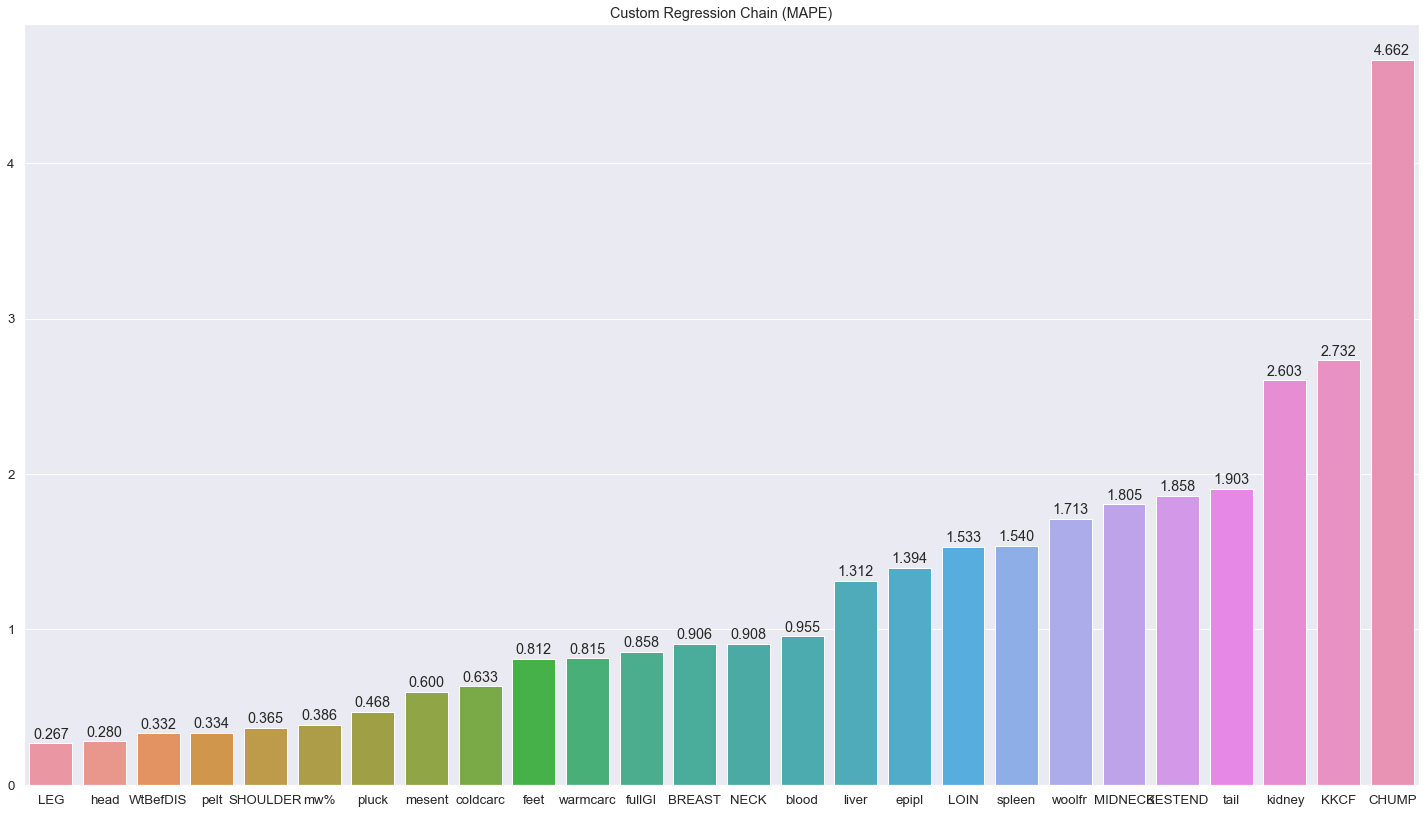

In [7]:
chain_links_2 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),
    (MultiOutputRegressor(xgb_reg), ['LEG', 'BREAST', 'BESTEND']),
    (MultiOutputRegressor(xgb_reg), ['CHUMP', 'woolfr', 'MIDNECK', 'pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'NECK', 'SHOULDER']),
    (MultiOutputRegressor(xgb_reg), ['pluck', 'LOIN', 'head', 'tail']),
    (MultiOutputRegressor(xgb_reg), ['feet', 'blood', 'spleen']),
    (MultiOutputRegressor(xgb_reg), ['fullGI']),
    (MultiOutputRegressor(xgb_reg), ['epipl', 'mesent', 'KKCF', 'mw%']),
]

# Run Chain Regressor & show results
chain_reg = ChainRegressor(chain_links_2)
clinks = chain_reg.fit(X_train, y_train)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print_avg_scores(scores, 'Custom Chain Regressor Based on Feature Importances #2')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Custom Regression Chain (MAPE)')

### Μη-σημαντικά Χαρακτηριστικά
Στο προηγούμενο Notebook παρατηρήσαμε πως κάποια χαρακτηριστικά δέν είναι σχεδόν καθόλου σημαντικά για κανένα χαρ/κο. 
Με βάση αυτή τη παρατήρηση θα δοκιμάσουμε να αφήσουμε τη πρόβλεψη αυτών των χαρακτηριστικών για το τέλος της αλυσίδας
μήπως και μειώσουμε το σφάλμα.

Custom Chain Regressor Based on Feature Importances #3
R2 score: 0.8130833337317024
MAE: 0.22045806240851112
RMSE: 0.31348422914207724
MAPE: 1.2608629626317895



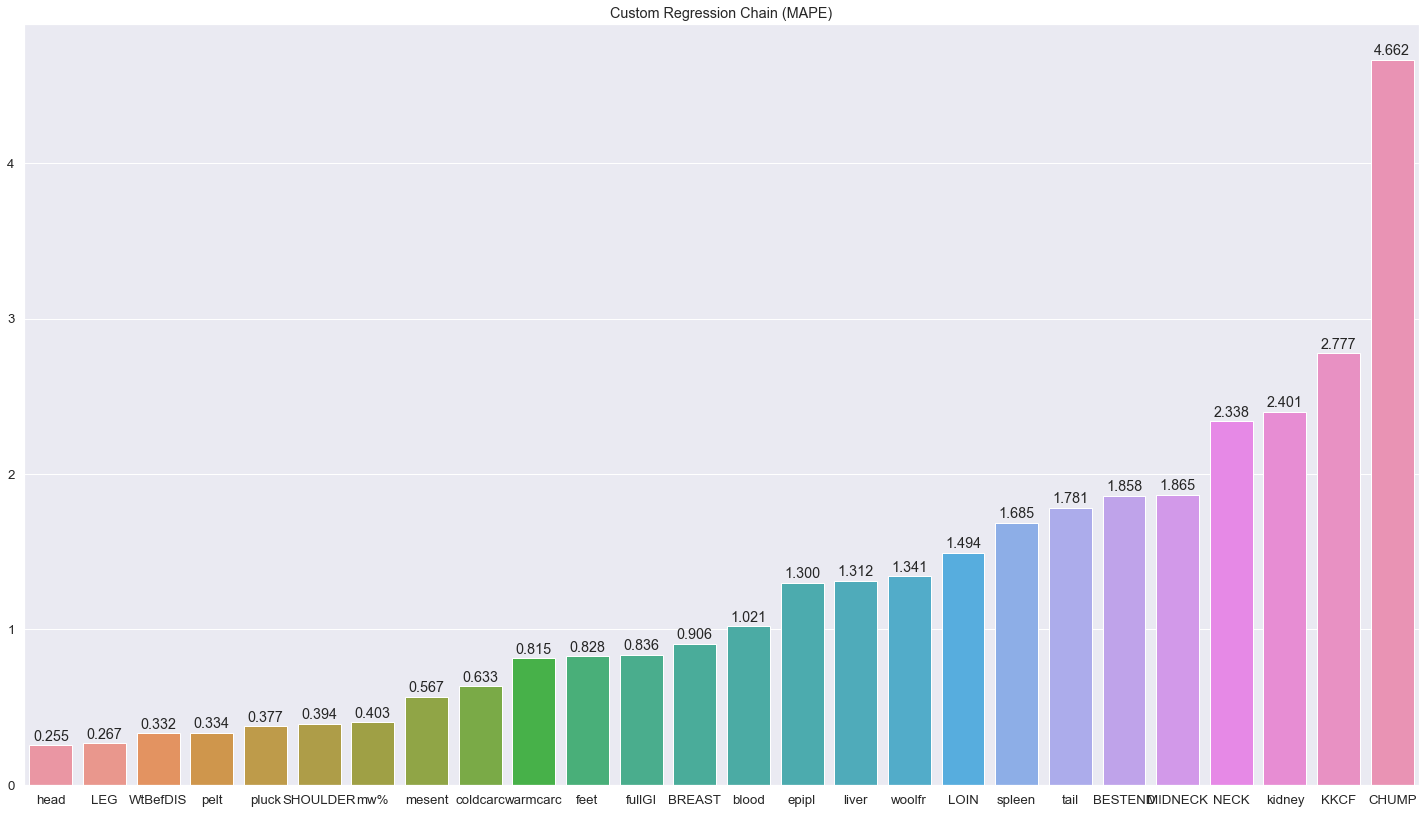

In [8]:
chain_links_3 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),
    (MultiOutputRegressor(xgb_reg), ['LEG', 'BREAST', 'BESTEND']),
    (MultiOutputRegressor(xgb_reg), ['CHUMP', 'pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'SHOULDER']),
    (MultiOutputRegressor(xgb_reg), ['pluck', 'LOIN']),
    (MultiOutputRegressor(xgb_reg), ['feet']),
    (MultiOutputRegressor(xgb_reg), ['woolfr', 'blood', 'spleen', 'head', 'tail', 'MIDNECK', 'NECK']),
    (MultiOutputRegressor(xgb_reg), ['fullGI']),
    (MultiOutputRegressor(xgb_reg), ['epipl', 'mesent', 'KKCF', 'mw%']),
    # (MultiOutputRegressor(xgb_reg), ['mw%']),

]

# Run Chain Regressor & show results
chain_reg = ChainRegressor(chain_links_3)
clinks = chain_reg.fit(X_train, y_train)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print_avg_scores(scores, 'Custom Chain Regressor Based on Feature Importances #3')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Custom Regression Chain (MAPE)')

* Το μέσο σφάλμα αυξήθηκε.
* Το σφάλμα των μεταβλητών head, pluck, mesent, epipl, LOIN, woolfr, tail και kidney μειώθηκε.
* Το σφάλμα των μεταβητών SHOULDER, mw%, feet, fullGI, NECK!, blood, spleen, MIDNECK και KKCF αυξήθηκε.
* Το σφάλμα της μεταβλητής "NECK" αυξήθηκε κατα μεγάλο βαθμό.

Με βάση τις παραπάνω παρατηρήσεις θα κάνουμε τις ακόλουθες αλλαγές στη σειρά πρόβλεψης:


Custom Chain Regressor Based on Feature Importances #4
R2 score: 0.815808723687636
MAE: 0.21988965548940412
RMSE: 0.31195699202750365
MAPE: 1.194224124098298



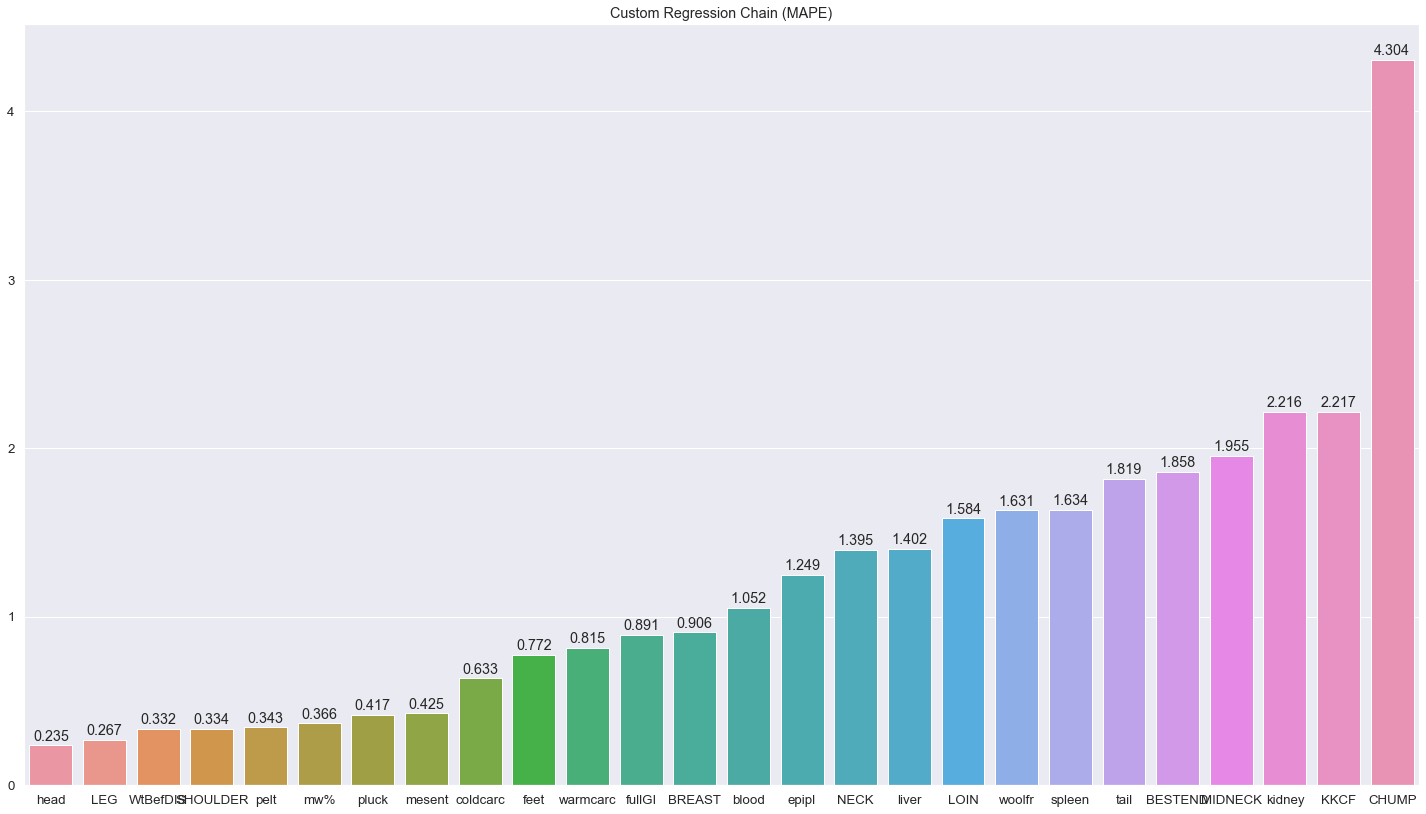

In [9]:
chain_links_4 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),
    (MultiOutputRegressor(xgb_reg), ['NECK', 'LEG', 'BREAST', 'BESTEND']),
    (MultiOutputRegressor(xgb_reg), ['CHUMP', 'pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'SHOULDER']),
    (MultiOutputRegressor(xgb_reg), ['pluck', 'LOIN']),
    (MultiOutputRegressor(xgb_reg), ['feet']),
    (MultiOutputRegressor(xgb_reg), ['fullGI']),
    (MultiOutputRegressor(xgb_reg), ['woolfr', 'blood', 'spleen', 'head', 'tail', 'MIDNECK']),

    (MultiOutputRegressor(xgb_reg), ['epipl', 'mesent', 'KKCF', 'mw%']),
]

# Run Chain Regressor & show results
chain_reg = ChainRegressor(chain_links_4)
clinks = chain_reg.fit(X_train, y_train)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print_avg_scores(scores, 'Custom Chain Regressor Based on Feature Importances #4')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Custom Regression Chain (MAPE)')

* Μεταφέροντας το NECK πιό ψηλά στην αλυσίδα, πετύχαμε μια μικρή μείωση του μέσου σφάλματος η οποία ωοφείλεται κυρίως
στη μεγάλη μείωση τους σφάλματος του NECK.

### Περαιτέρω Διάσπαση της αλυσίδας
Στις δοκιμές που κάναμε παραπάνω, στο 4ο στάδιο της αλυσίδας οι μεταβλητές BREAST, LEG, NECK και BESTEND προβέπονται
παράλληλα με αποτέλεσμα να μην αξιοποιούνται οι μεταξύ τους συσχετίσεις που γνωρίζουμε πως υπάρχουν.
Προκειμένου λοιπόν να εκμεταλλευτούμε αυτές τις συσχετίσεις θα δοκιμάσουμε να τις υπολογίσουμε ακολουθιακά σε
διαφορετικά στάδια της αλυσίδας.

Custom Chain Regressor Based on Feature Importances #5
R2 score: 0.8211419714387903
MAE: 0.21662204634476823
RMSE: 0.3090731571132537
MAPE: 1.110368028275712



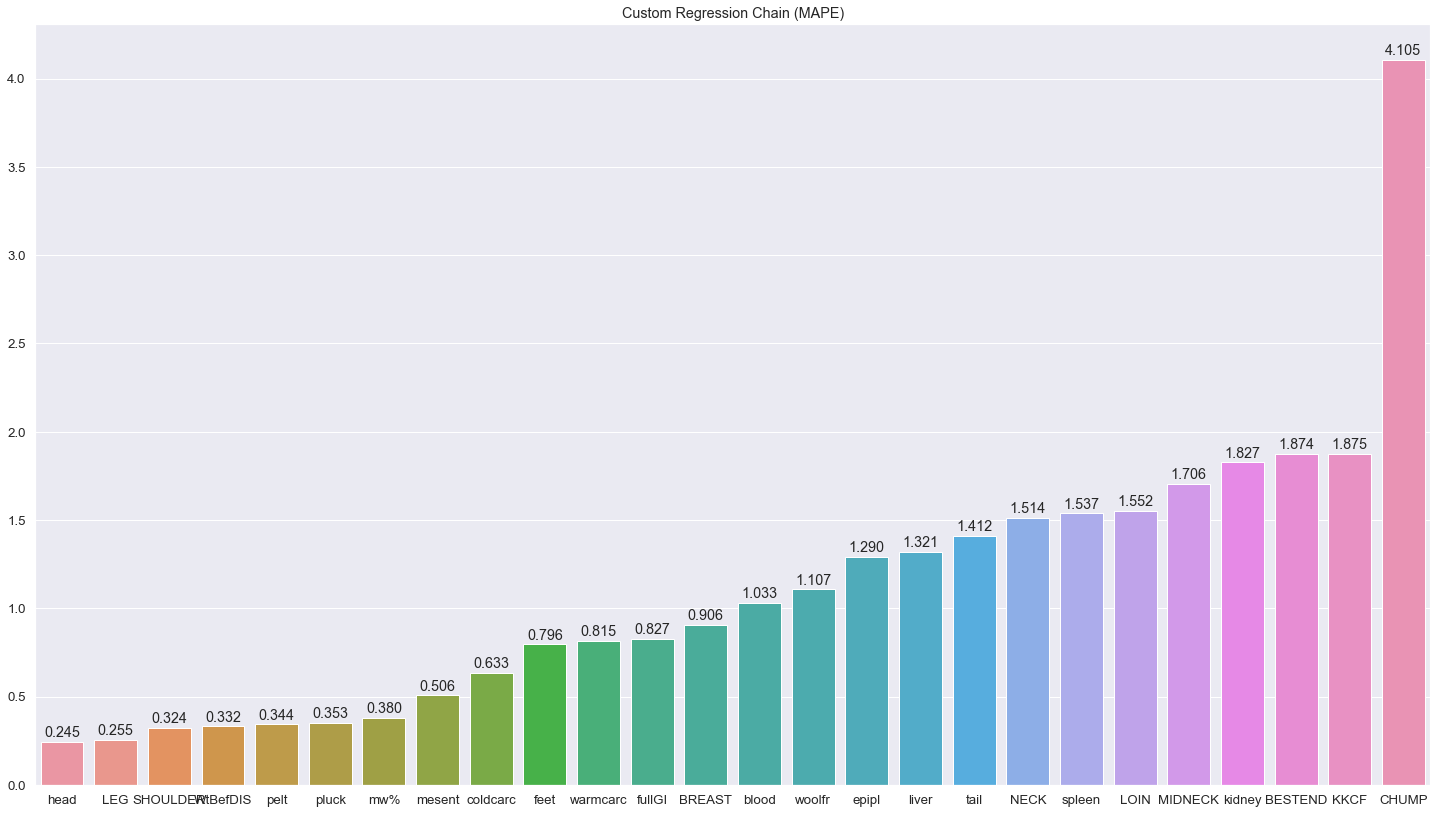

In [10]:
chain_links_5 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),

    (MultiOutputRegressor(xgb_reg), ['BREAST']),
    (MultiOutputRegressor(xgb_reg), ['LEG']),
    (MultiOutputRegressor(xgb_reg), ['NECK']),
    (MultiOutputRegressor(xgb_reg), ['BESTEND']),

    (MultiOutputRegressor(xgb_reg), ['CHUMP', 'pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'SHOULDER']),
    (MultiOutputRegressor(xgb_reg), ['pluck', 'LOIN']),
    (MultiOutputRegressor(xgb_reg), ['feet']),
    (MultiOutputRegressor(xgb_reg), ['fullGI']),
    (MultiOutputRegressor(xgb_reg), ['woolfr', 'blood', 'spleen', 'head', 'tail', 'MIDNECK']),
    (MultiOutputRegressor(xgb_reg), ['epipl', 'mesent', 'KKCF', 'mw%']),

]

# Run Chain Regressor & show results
chain_reg = ChainRegressor(chain_links_5)
clinks = chain_reg.fit(X_train, y_train)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print_avg_scores(scores, 'Custom Chain Regressor Based on Feature Importances #5')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Custom Regression Chain (MAPE)')

Πράγματι, η εκμετάλλευση των συσχετίσων μεταξύ των μεταβλητών που αναφέραμε στην αλυσίδα είχε ως αποτέλεσμα τη μείωση
του σφάλματος.

### Χαρακτηριστικό "CHUMP"
Παρατηρήσαμε πως το χαρ/κο CHUMP έχει πολύ υψηλό σφάλμα και μάλιστα υπολογίζεται σε σχετικά αρχικό στάδιο της αλυσίδας,
με αποτέλεσμα να επηρεάζει αρνητικά τις επόμενες προβλέψεις. Για το λόγο αυτό, θα δοκιμάσουμε να μεταφέρουμε τη πρόβλεψή
του στο τέλος της αλυσίδας.

Custom Chain Regressor Based on Feature Importances #6
R2 score: 0.8163248572934252
MAE: 0.2211843906342927
RMSE: 0.31306797875713416
MAPE: 1.0339380956770479



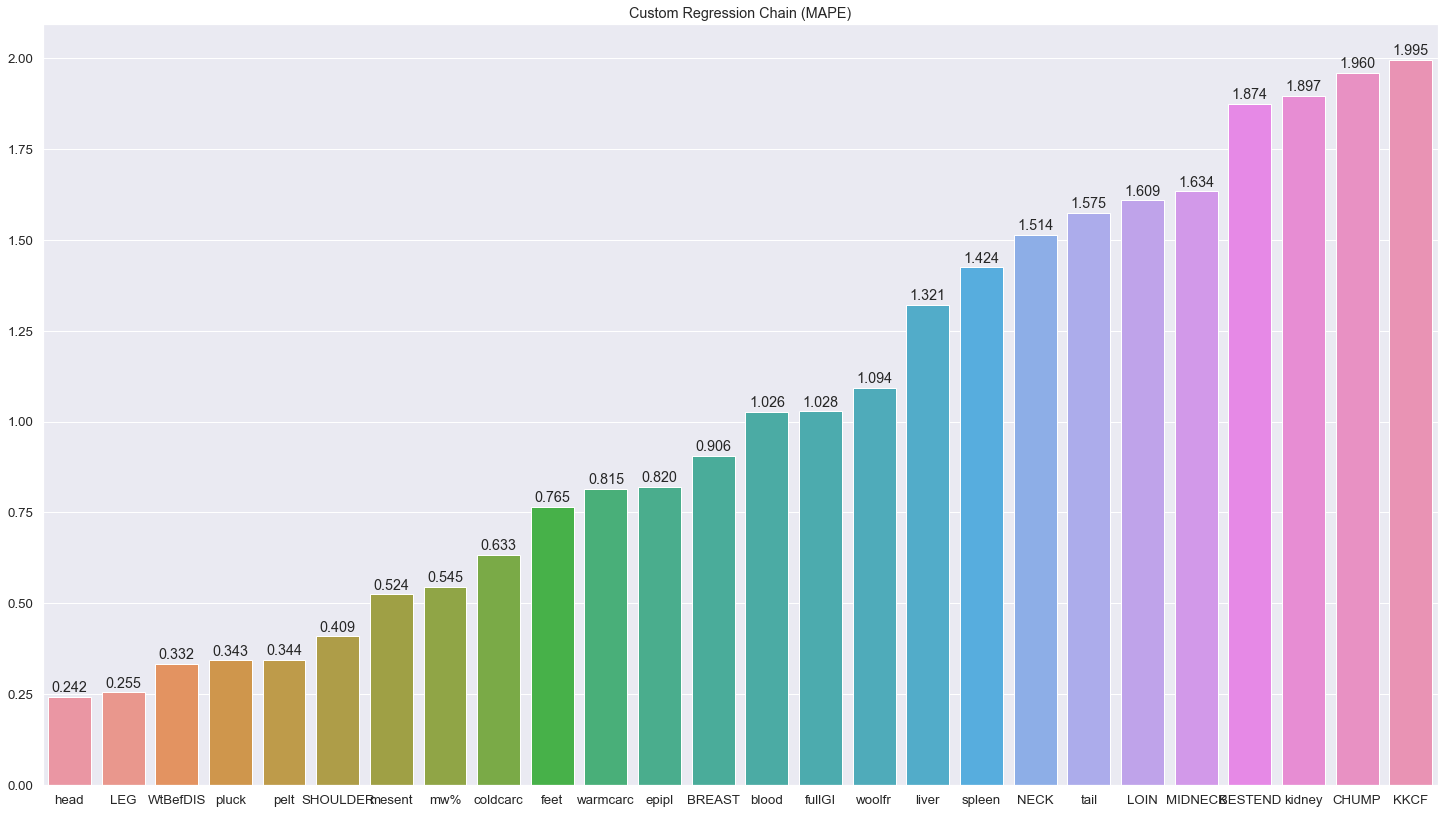

In [13]:
chain_links_6 = [
    (LinearRegression(), ['warmcarc']),
    (LinearRegression(), ['coldcarc']),
    (LinearRegression(), ['WtBefDIS']),

    (MultiOutputRegressor(xgb_reg), ['BREAST']),
    (MultiOutputRegressor(xgb_reg), ['LEG']),
    (MultiOutputRegressor(xgb_reg), ['NECK']),
    (MultiOutputRegressor(xgb_reg), ['BESTEND']),

    (MultiOutputRegressor(xgb_reg), ['pelt', 'liver']),
    (MultiOutputRegressor(xgb_reg), ['kidney', 'SHOULDER']),
    (MultiOutputRegressor(xgb_reg), ['pluck', 'LOIN']),
    (MultiOutputRegressor(xgb_reg), ['feet']),
    (MultiOutputRegressor(xgb_reg), ['fullGI']),
    (MultiOutputRegressor(xgb_reg), ['woolfr', 'blood', 'spleen', 'head', 'tail', 'MIDNECK']),
    (MultiOutputRegressor(xgb_reg), ['epipl', 'mesent', 'mw%']),

    (LinearRegression(), ['CHUMP']),
    (MultiOutputRegressor(xgb_reg), ['KKCF']),
]

# Run Chain Regressor & show results
chain_reg = ChainRegressor(chain_links_6)
clinks = chain_reg.fit(X_train, y_train)
scores = mo_reg_scorer(chain_reg, X_test, y_test)
print_avg_scores(scores, 'Custom Chain Regressor Based on Feature Importances #6')
scores_barplot(scores['rv_scores_mape'], y_test.columns, title='Custom Regression Chain (MAPE)')


* Παρατηρούμε ότι βάζοντας το CHUMP στο τέλος της αλυσίδας και χρησμοποιώντας linear regression αντι XGBoost, το MAPE
πράγματι μειώνεται περίπου στο μισό για το CHUMP ενώ οι περισσότερες απο τις υπόλοιπες μεταβλητές επηρεάζονται λίγο με
κάποιες να παρουσιάζουν μειωμένο MAPE και κάποιες αυξημένο.

* Ωστόσο, παρά τη μείωση που παρατηρείται στο MAPE, οι υπόλοιπες μετρικές του σφάλματος (MAE, RMSE) αυξάνονται ελαφρώς
και το R2 score μειώνεται αντίστοιχα.